In [1]:
import numpy as np
class Particle:
    def __init__(self, x, y, ang_speed):
        self.x = x
        self.y = y
        self.ang_vel = ang_speed
        self.ang_speed = ang_speed
class ParticleSimulator:
    def __init__(self, particles):
        self.particles = particles
    def evolve_cython(self, dt):
        timestep = 0.00001
        nsteps = int(dt/timestep)
        
        r_i = np.array([[p.x, p.y] for p in self.particles])
        ang_speed_i = np.array([p.ang_speed for p in self.particles])
        
        c_evolve(r_i, ang_speed_i, timestep, nsteps)
        for i, p in enumerate(self.particles):
            p.x, p.y = r_i[i]
    def evolve_python(self, dt):
        timestep = 0.00001
        nsteps = int(dt/timestep)
        
        for i in range(nsteps):
            for p in self.particles:
                #計算方向
                norm = (p.x**2+p.y**2)**0.5
                v_x = -p.y/norm
                v_y = p.x/norm
                
                #計算位移
                d_x = timestep * p.ang_vel * v_x
                d_y = timestep * p.ang_vel * v_y
                
                p.x += d_x
                p.y += d_y                
                #重複
    def evolve_numpy(self, dt):
        timestep = 0.00001
        nsteps = int(dt/timestep)
        
        r_i = np.array([[p.x, p.y] for p in self.particles])
        ang_speed_i = np.array([p.ang_speed for p in self.particles])
        v_i = np.empty_like(r_i)

        for i in range(nsteps):
            norm_i = np.sqrt((r_i**2).sum(axis = 1))

            v_i = r_i[:,[1,0]]
            v_i[:, 0] *= -1
            v_i /= norm_i[:, np.newaxis]

            d_i =timestep * ang_speed_i[:, np.newaxis] * v_i

            r_i += d_i
            for i, p in enumerate(self.particles):
                p.x, p.y = r_i[i]                

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
def visualize(simulator):
    X = [p.x for p in simulator.particles]
    Y = [p.y for p in simulator.particles]
    fig = plt.figure()
    ax = plt.subplot(111, aspect = "equal")
    line, = ax.plot(X ,Y ,"ro") #此逗號不可少
    
    #指定坐標軸範圍
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    
    def init():
        line.set_data([], [])
        return line,
    def animate(i):
        #粒子移動0.01個時間單位
        simulator.evolve(0.01)
        X = [p.x for p in simulator.particles]
        Y = [p.y for p in simulator.particles]
      
        line.set_data(X, Y)
        return line,
    anim = animation.FuncAnimation(fig = fig,
                               func = animate,
                              init_func= init,
                              blit = True,
                              interval = 10)
    return anim

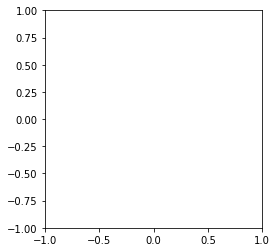

In [3]:
def test_visualize():
    particles = [Particle(0.3, 0.5, 1),
                Particle(0.0, -0.5, -1),
                Particle(-0.1, -0.4, 3)]
    simulator = ParticleSimulator(particles)
    visualize(simulator)
if __name__ == "__main__":
    test_visualize()

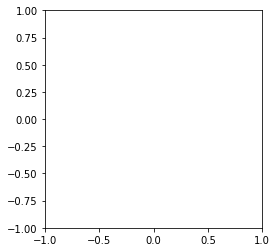

In [4]:
def test_evolve():
    particles = [Particle(0.3, 0.5, +1),
                Particle(0.0, -0.5, -1),
                Particle(-0.1, -0.4, +3)]
    simulator = ParticleSimulator(particles)
    
    simulator.evolve(0.1)
    
    p0, p1, p2 = particles
    def fequal(a, b, eps = 1e-5):
        return abs(a - b) < eps
    assert fequal(p0.x, 0.210269)
    assert fequal(p0.y, 0.543863)
    
    assert fequal(p1.x, -0.099334)
    assert fequal(p1.y, -0.490034)
    
    assert fequal(p2.x, 0.191358)
    assert fequal(p2.y, -0.365227)
if __name__ == "__main__":
    test_visualize()    
    

In [5]:
import cevolve

In [6]:
# def c_evolve(r_i, ang_speed_i, timestep, nsteps):
#     v_i = np.empty_like(r_i)

#     for i in range(nsteps):
#         norm_i = np.sqrt((r_i**2).sum(axis = 1))

#         v_i = r_i[:,[1,0]]
#         v_i[:, 0] *= -1
#         v_i /= norm_i[:, np.newaxis]

#         d_i =timestep * ang_speed_i[:, np.newaxis] * v_i

#         r_i += d_i

In [7]:
from random import uniform
def benchmark(npart = 100, method = "python"):
    particles = [Particle(uniform(-1.0, 1.0),
                         uniform(-1.0, 1.0),
                         uniform(-1.0, 1.0))
                for i in range(npart)]
    simulator = ParticleSimulator(particles)
    if method == "python":
        simulator.evolve_python(0.1)
    elif method == "cython":
        simulator.evolve_cython(0.1)


def benchmark_memory():
    particles = [Particle(uniform(-1.0, 1.0),
                         uniform(-1.0, 1.0),
                         uniform(-1.0, 1.0))
                for i in range(10000)]
    simulator =  ParticleSimulator(particles)
    simulator.evolve_python(0.001)
if __name__ == '__main__':
    benchmark(100,"cython")

In [8]:
%timeit benchmark(1000,"cython")

856 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
